In [109]:
import heapq
class Event:
    '''
    Store the properties of one event in the Schedule class defined below. Each
    event has a time at which it needs to run, a function to call when running
    the event, along with the arguments and keyword arguments to pass to that
    function.
    
    Attributes
    ----------
    timestamp: float
        The scheduled time for the event to occur.
    function: callable
        The function to be called when the event is run.
    args: tuple
        Positional argumens to be passed to the function.
    kwargs: dict
        Keyword arguments to be passed to the function.
    '''
    def __init__(self, timestamp, function, *args, **kwargs):
        self.timestamp = timestamp
        self.function = function
        self.args = args
        self.kwargs = kwargs

    def __lt__(self, other):
        '''
        Define less-than for priority queue sorting. 
        An event is considered "less" if its timestamp is earlier.
        
        Parameters
        ----------
        other
            Another event to compare against.
        
        Returns
        -------
        bool
            True if this event's timestamp is less than the other's, otherwise False.
        '''
        return self.timestamp < other.timestamp

    def run(self, schedule):
        '''
        Execute the event's function, passing the schedule and any additional arguments.
        
        Parameters
        ----------
        schedule: Schedule
            the schedule in which the event is being run.
        '''
        self.function(schedule, *self.args, **self.kwargs)


class Schedule:
    '''
    Implement an event schedule using a priority queue. You can add events and
    run the next event.
    
    The `now` attribute contains the time at which the last event was run.
    
    Attributes
    ----------
    now: float
        The current time in the schedule
    priority_queue: list
        A min-heap priority queue of events.

    '''
    def __init__(self):
        self.now = 0  
        self.priority_queue = []  
    
    def add_event_at(self, timestamp, function, *args, **kwargs):
        '''
        Add an event to the schedule at a specific time
        
        Parameters
        ----------
        timestamp: float 
            The time at which the event should occur. 
        function: callable
            The function to be called when the event occurs.
        args: tuple
            Positional arguments to be passed to the function.
        kwargs: dict
            Keyword arguments to be passed to the function.
        '''
        heapq.heappush(
            self.priority_queue,
            Event(timestamp, function, *args, **kwargs))
    
    def add_event_after(self, interval, function, *args, **kwargs):
        '''
        Add an event to the schedule after a specified time interval.
        
        Parameters
        ----------
        interval: float
            The time interval after the current time when the event should occur.
        function: calable
            The function to be called when the event occurs.
        args: tuple
            Positional arguments to be passed to the function.
        kwargs: dict
            Keyword arguments to be passed to the function.
        '''
        self.add_event_at(self.now + interval, function, *args, **kwargs)
    
    def next_event_time(self):
        '''
        Get the time of the next event to occur.
        
        Returns
        -------
        float
            The timestamp of the next event.
        '''
        return self.priority_queue[0].timestamp

    def run_next_event(self):
        '''
        Get the time of the next event to occur.
        
        Returns
        -------
        float
            The timestamp of the next event.
        '''
        event = heapq.heappop(self.priority_queue)
        self.now = event.timestamp
        event.run(self)

In [110]:
import scipy.stats as sts
import random
class Queue_MG1: 
    '''
    Represents a single queue in an M/G/1 system. This class manages the queue
    operations such as adding a person to the queue, starting and finishing serving a person.
    
    Attributes
    ----------
    service_distribution: scipy.stats distribution
        The probability distribution of service times for this queue.
    additional_screening_prob: float
        The probability a given traveler needs to undergo additional security.
    people_in_queue: int
        The number of people currently waiting in the queue.
    people_being_served: int
        The number of people currently being served.
    entry_times: list of float
        A priority queue (min-heap) of entry times of people in the queue. 
        The smallest entry time is at the front of the queue.
    max_queue_length: int
        The maximum length that the queue has reached during the simulation.
    '''
    def __init__(self, service_distribution, additional_screening_prob):
        '''
        Initializes the Queue_MG1 instance with a service time distribution.
        
        Parameters
        ----------
        service_distribution: scipy.stats distribution
        additional_screening_prob: float
        '''
        self.service_distribution = service_distribution
        self.additional_screening_prob = additional_screening_prob
        self.people_in_queue = 0
        self.people_being_served = 0
        self.entry_times = []
        self.max_queue_length = 0

    def add_person(self, schedule, airport):
        '''
        Adds a person to the queue and starts serving them if the server is available.
        There's a chance that the person will require additional screening.

        Paramerers
        ----------
        schedule: Schedile
            The event schedule to which the serving event will be added.
        airport: Airport_MG1
            The airport instance to handle additional screening if required.
        '''
        self.people_in_queue += 1
        self.max_queue_length = max(self.max_queue_length, self.people_in_queue)
        heapq.heappush(self.entry_times, schedule.now)
        if self.people_being_served < 1:
            schedule.add_event_after(0, self.start_serving_person, airport)
            
    def start_serving_person(self, schedule, airport):
        '''
        Moves a person from the queue to being served, schedules the end of their service.
        There's a chance that the person will require additional screening.

        Parameters
        ----------
        schedule: Schedule
            The event schedule to which the finish serving event will be added.
        airport: Airport_MG1
            The airport instance to handle additional screening if required.
        '''
        if self.people_in_queue > 0:
            wait_time = schedule.now - heapq.heappop(self.entry_times)
            airport.cumulative_wait_time += wait_time
            airport.total_served += 1
            self.people_in_queue -= 1
            self.people_being_served += 1
            if random.random() < self.additional_screening_prob:
                airport.add_additional_screening(self, schedule)
            else:
                service_time = self.service_distribution.rvs()
                schedule.add_event_after(service_time, self.finish_serving_person, airport)
            
    def finish_serving_person(self, schedule, airport):
        '''
        Finishes serving a person and starts serving the next person if the queue is not empty.
        
        Parameters
        ----------
        schedule: Schedule
            The event schedule to which the next serving event will be added.
        airport: Airport_MG1
            The airport instance to handle additional screening if required.
        '''
        self.people_being_served -= 1
        if self.people_in_queue > 0:
            schedule.add_event_after(0, self.start_serving_person, airport)
            
    def __lt__(self, other):
        '''
        Less-than compariosn based on the total number of people in the queue and being served.
        
        Parameters
        ----------
        other: Queue_MG1
            Another Queue_MG1 instance to compare against.
        
        Returns
        -------
        bool
            True if this queue's total people are less than the other's, otherwise False.
        '''
        total_self = self.people_in_queue + self.people_being_served
        total_other = other.people_in_queue + other.people_being_served
        return total_self < total_other


class Airport_MG1:
    '''
    Represents an airport security system with multiple queues (M/G/1 type) and an additional
    security officer for extra screening. Manages the addition of people to queues and handles
    additional security screening.

    Attributes
    ----------
    queues: list of Queue_MG1
        A list of queues in the airport.
    arrival_distribution: scipy.stats distribution
        The probability distribution of arrival times of people to the airport.
    extra_screening_distribution: scipy.stats distribution
        The probability distribution for the duration of additional security screenings.
    additional_screening_prob: float
        The probability a given traveler needs to undergo additional security.
    queues_needing_extra_screening: list of tuples
        A priority queue (min-heap) where each element is a tuple (timestamp, queue) 
        representing a queue that requires additional screening. The timestamp indicates 
        when the queue was added to this priority queue.
    is_extra_screening_busy: bool
        Flag indicating if the extra security officer is currently busy.
    cumulative_wait_time: float
        The cumulative waiting time of all people in the airport.
    total_served: int
        The total number of people served in the airport.
    '''
    def __init__(self, arrival_distribution, service_distribution, num_queues, extra_screening_distribution, additional_screening_prob):
        self.queues = [Queue_MG1(service_distribution, additional_screening_prob) for _ in range(num_queues)]
        self.arrival_distribution = arrival_distribution
        self.extra_screening_distribution = extra_screening_distribution
        self.queues_needing_extra_screening = []
        self.is_extra_screening_busy = False
        self.cumulative_wait_time = 0  
        self.total_served = 0

    def add_additional_screening(self, queue, schedule):
        '''
        Adds a queue to the list of queues requiring additional security screening. If the extra
        screening officer is not currently busy, initiates the extra screening process.

        Parameters
        ----------
        queue : Queue_MG1
            The queue which has a person requiring additional screening.
        schedule : Schedule
            The event schedule to which the extra screening event will be added if the extra
            screening officer is available.
        '''
        heapq.heappush(self.queues_needing_extra_screening, (schedule.now, queue))
        if not self.is_extra_screening_busy:
            self.start_extra_screening(schedule)

    def start_extra_screening(self, schedule):
        '''
        Starts the extra screening process for the first queue in the list of queues needing additional
        screening, if there are any queues in the list and the extra screening officer is not currently busy.

        Parameters
        ----------
        schedule : Schedule
            The event schedule to which the end of the extra screening event will be added.
        '''
        if self.queues_needing_extra_screening and not self.is_extra_screening_busy:
            self.is_extra_screening_busy = True
            extra_screening_time = self.extra_screening_distribution.rvs()
            schedule.add_event_after(extra_screening_time, self.finish_extra_screening)

    def finish_extra_screening(self, schedule):
        '''
        Completes the extra screening process for the first queue in the list of queues needing additional
        screening. Resumes normal processing of the first person in that queue and checks if there are more
        queues needing extra screening.

        Parameters
        ----------
        schedule : Schedule
            The event schedule to which the next extra screening or normal serving event will be added.

        Notes
        -----
        This method removes a queue from the 'queues_needing_extra_screening' list, resets the
        'is_extra_screening_busy' flag to False, and calls 'start_serving_person' for the queue that
        just completed extra screening. If there are more queues waiting for extra screening, it calls
        'start_extra_screening' to initiate the process for the next queue.
        '''
        _, queue = heapq.heappop(self.queues_needing_extra_screening)
        self.is_extra_screening_busy = False
        # Resume normal processing of the first person in the queue
        queue.start_serving_person(schedule, self)
        # Check if there are more queues needing extra screening
        if self.queues_needing_extra_screening:
            self.start_extra_screening(schedule)

    def add_person(self, schedule):
        '''
        Adds a person to the shortest queue and schedules the next arrival.

        Parameters
        ----------
        schedule : Schedule
            The event schedule to which the next arrival will be added.
        '''
        shortest_queue = min(self.queues)
        shortest_queue.add_person(schedule, self)
        schedule.add_event_after(
            self.arrival_distribution.rvs(),
            self.add_person)

    def run(self, schedule):
        '''
        Starts the airport simulation by scheduling the first person's arrival.

        Parameters
        ----------
        schedule : Schedule
            The event schedule to which the initial arrival will be added.
        '''
        schedule.add_event_after(
            self.arrival_distribution.rvs(),
            self.add_person)
        

def run_simulation_MG1(arrival_distribution, service_distribution, extra_screening_distribution, run_until, num_queues, additional_screening_prob):
    '''
    Runs the airport security simulation with M/G/1 queues, considering the arrival times, service times,
    and extra screening times.

    Parameters
    ----------
    arrival_distribution : scipy.stats distribution
        The probability distribution of arrival times of people to the airport.
    service_distribution : scipy.stats distribution
        The probability distribution of service times in the queues.
    extra_screening_distribution : scipy.stats distribution
        The probability distribution for the duration of additional security screenings.
    run_until : float
        The time until which the simulation runs.
    num_queues : int
        The number of queues in the airport.
    additional_screening_prob: float
        The probability a given traveler needs to undergo additional security.

    Returns
    -------
    Airport_MG1
        The instance of the airport after the simulation has run.
    '''
    schedule = Schedule()
    airport = Airport_MG1(arrival_distribution, service_distribution, num_queues, extra_screening_distribution, additional_screening_prob)
    airport.run(schedule)
    while schedule.next_event_time() < run_until:
        schedule.run_next_event()
    return airport

In [120]:
import numpy as np

# Exponential distribution with lambda = 10
arrival_distribution = sts.expon(scale = 1/ 10)

# Create truncated normal distribution with lower bound at 0 and upper bound at infinity
mu = 1/2
sigma = 1/6
service_distribution = sts.truncnorm( a=(0 - mu) / sigma, b=np.inf, loc=mu, scale=sigma)

run_until = 200  # in minutes

# Define extra screening distribution
additional_screening_prob = 0.03
mu_extra = 2
sigma_extra = 2
extra_screening_distribution = sts.truncnorm(a=(0 - mu_extra) / sigma_extra, b=np.inf, loc=mu_extra, scale=sigma_extra)

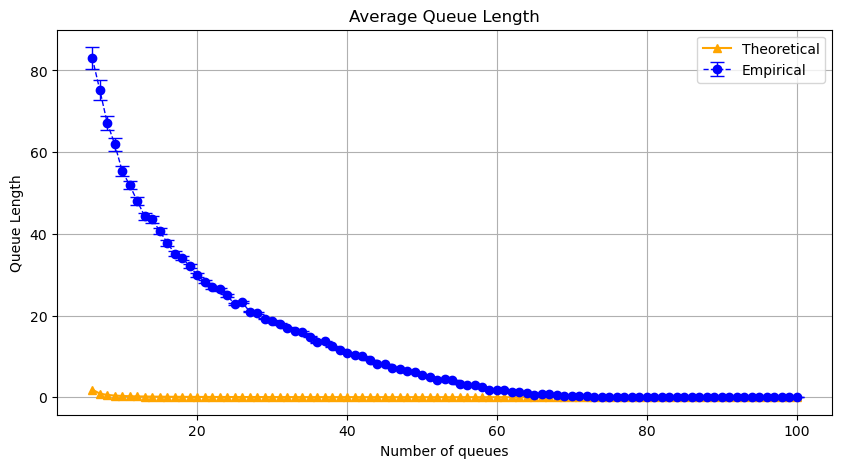

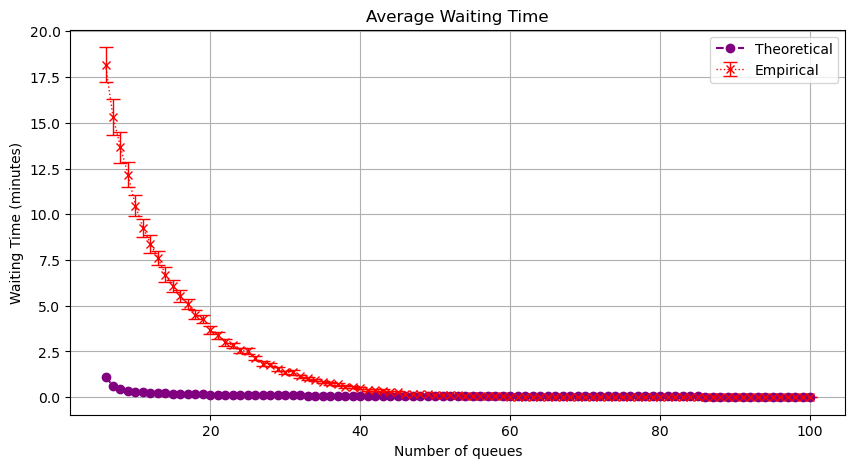

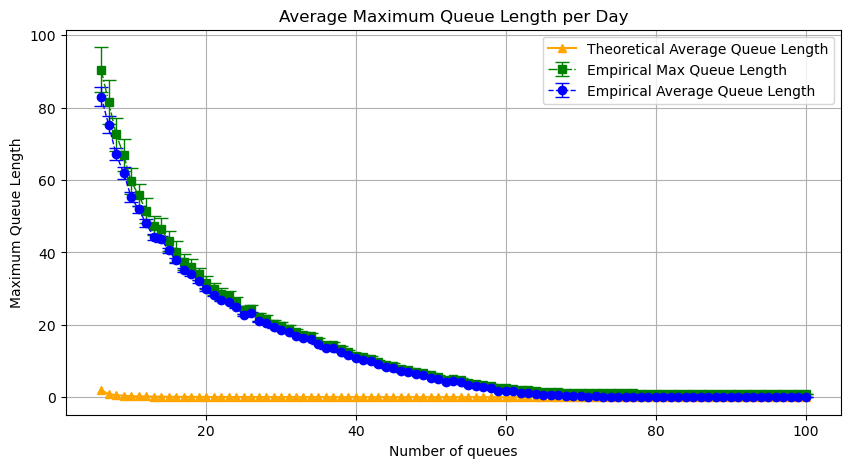

In [121]:
import matplotlib.pyplot as plt

x = list(range(6,101))  # Number of queues
y_queue = []
y_wait = []
y_error_queue = []
y_error_wait = []
y_max_queue = []
y_error_max_queue = []

for num_queues in x:
    queue_lengths = []
    wait_times = []
    max_queue_lengths = []
    for i in range(100):
        airport = run_simulation_MG1(arrival_distribution, service_distribution, extra_screening_distribution, run_until, num_queues, additional_screening_prob)
        for queue in airport.queues:
            queue_lengths.append(queue.people_in_queue)
        #Average wait time for this simulation
        avg_wait_time = airport.cumulative_wait_time / airport.total_served if airport.total_served > 0 else 0
        wait_times.append(avg_wait_time)
        max_length = max(queue.max_queue_length for queue in airport.queues)
        max_queue_lengths.append(max_length)
        
    # Average queue length and its confidence interval
    mean_queue = np.mean(queue_lengths)
    sem_queue = sts.sem(queue_lengths)
    conf_int_queue = 1.96 * sem_queue

    # Average waiting time and its confidence interval
    mean_wait = np.mean(wait_times)
    sem_wait = sts.sem(wait_times)
    conf_int_wait = 1.96 * sem_wait
    
    # Calculate average and confidence interval
    mean_max_queue = np.mean(max_queue_lengths)
    sem_max_queue = sts.sem(max_queue_lengths)
    conf_int_max_queue = 1.96 * sem_max_queue

    y_queue.append(mean_queue)
    y_wait.append(mean_wait)
    y_error_queue.append(conf_int_queue)
    y_error_wait.append(conf_int_wait)
    y_max_queue.append(mean_max_queue)
    y_error_max_queue.append(conf_int_max_queue)
    
# Plotting average queue length
plt.figure(figsize=(10, 5))
plt.errorbar(x, y_queue, y_error_queue, color='blue', marker='o', capsize=5, linestyle='--', linewidth=1, label='Empirical')
y_g = [250 / ((18*n-90)*(0.4*n+5.04)) for n in x]
plt.plot(x, y_g, color='orange', marker='^', linestyle='-', label='Theoretical')
plt.title('Average Queue Length')
plt.xlabel('Number of queues')
plt.ylabel('Queue Length')
plt.grid(True)
plt.legend()
plt.show()

# Plotting average waiting time
plt.figure(figsize=(10, 5))
plt.errorbar(x, y_wait, y_error_wait, color='red', marker='x', capsize=5, linestyle=':', linewidth=1, label='Empirical')
y_f = [25*n / ((18*n-90)*(0.4*n+5.04)) for n in x]
plt.plot(x, y_f, color='purple', marker='o', linestyle='--', label='Theoretical')
plt.title('Average Waiting Time')
plt.xlabel('Number of queues')
plt.ylabel('Waiting Time (minutes)')
plt.grid(True)
plt.legend()
plt.show()

# Plotting average maximum queue length
plt.figure(figsize=(10, 5))
plt.errorbar(x, y_max_queue, y_error_max_queue, color='green', marker='s', capsize=5, linestyle='-.', linewidth=1, label='Empirical Max Queue Length')
plt.errorbar(x, y_queue, y_error_queue, color='blue', marker='o', capsize=5, linestyle='--', linewidth=1, label='Empirical Average Queue Length')
y_g = [250 / ((18*n-90)*(0.4*n+5.04)) for n in x]
plt.plot(x, y_g, color='orange', marker='^', linestyle='-', label='Theoretical Average Queue Length')
plt.title('Average Maximum Queue Length per Day')
plt.xlabel('Number of queues')
plt.ylabel('Maximum Queue Length')
plt.grid(True)
plt.legend()
plt.show()

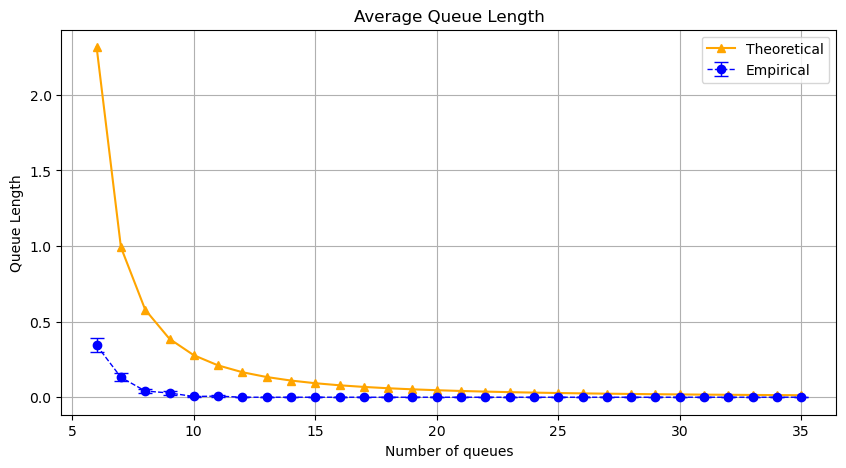

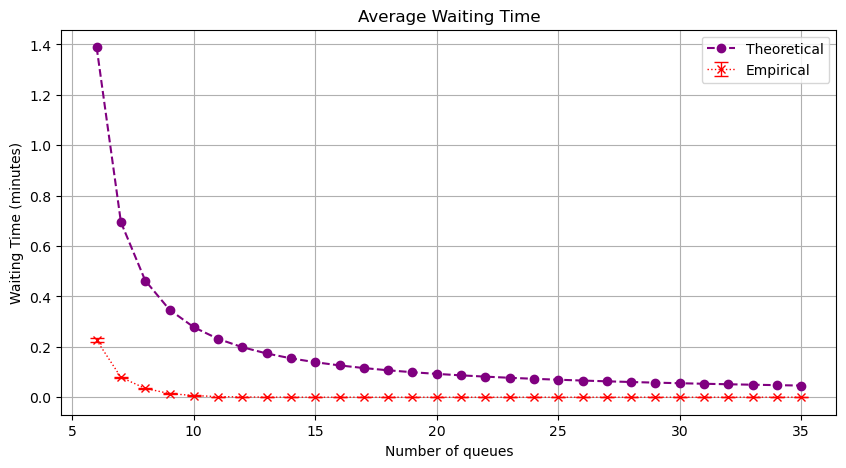

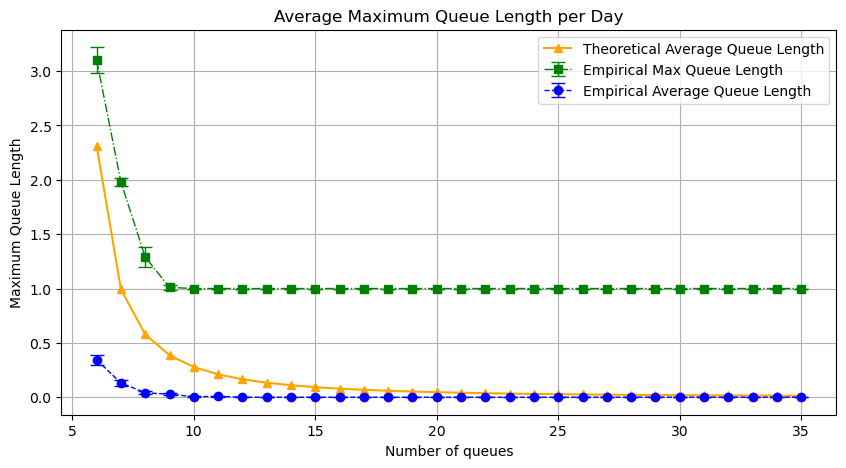

In [118]:
additional_screening_prob = 0
import matplotlib.pyplot as plt

x = list(range(6,36))  # Number of queues
y_queue = []
y_wait = []
y_error_queue = []
y_error_wait = []
y_max_queue = []
y_error_max_queue = []

for num_queues in x:
    queue_lengths = []
    wait_times = []
    max_queue_lengths = []
    for i in range(100):
        airport = run_simulation_MG1(arrival_distribution, service_distribution, extra_screening_distribution, run_until, num_queues, additional_screening_prob)
        for queue in airport.queues:
            queue_lengths.append(queue.people_in_queue)
        #Average wait time for this simulation
        avg_wait_time = airport.cumulative_wait_time / airport.total_served if airport.total_served > 0 else 0
        wait_times.append(avg_wait_time)
        max_length = max(queue.max_queue_length for queue in airport.queues)
        max_queue_lengths.append(max_length)
        
    # Average queue length and its confidence interval
    mean_queue = np.mean(queue_lengths)
    sem_queue = sts.sem(queue_lengths)
    conf_int_queue = 1.96 * sem_queue

    # Average waiting time and its confidence interval
    mean_wait = np.mean(wait_times)
    sem_wait = sts.sem(wait_times)
    conf_int_wait = 1.96 * sem_wait
    
    # Calculate average and confidence interval
    mean_max_queue = np.mean(max_queue_lengths)
    sem_max_queue = sts.sem(max_queue_lengths)
    conf_int_max_queue = 1.96 * sem_max_queue

    y_queue.append(mean_queue)
    y_wait.append(mean_wait)
    y_error_queue.append(conf_int_queue)
    y_error_wait.append(conf_int_wait)
    y_max_queue.append(mean_max_queue)
    y_error_max_queue.append(conf_int_max_queue)
    
# Plotting average queue length
plt.figure(figsize=(10, 5))
plt.errorbar(x, y_queue, y_error_queue, color='blue', marker='o', capsize=5, linestyle='--', linewidth=1, label='Empirical')
y_g = [250 / ((18*n-90)*n) for n in x]
plt.plot(x, y_g, color='orange', marker='^', linestyle='-', label='Theoretical')
plt.title('Average Queue Length')
plt.xlabel('Number of queues')
plt.ylabel('Queue Length')
plt.grid(True)
plt.legend()
plt.show()

# Plotting average waiting time
plt.figure(figsize=(10, 5))
plt.errorbar(x, y_wait, y_error_wait, color='red', marker='x', capsize=5, linestyle=':', linewidth=1, label='Empirical')
y_f = [25 / ((18*n-90)) for n in x]
plt.plot(x, y_f, color='purple', marker='o', linestyle='--', label='Theoretical')
plt.title('Average Waiting Time')
plt.xlabel('Number of queues')
plt.ylabel('Waiting Time (minutes)')
plt.grid(True)
plt.legend()
plt.show()

# Plotting average maximum queue length
plt.figure(figsize=(10, 5))
plt.errorbar(x, y_max_queue, y_error_max_queue, color='green', marker='s', capsize=5, linestyle='-.', linewidth=1, label='Empirical Max Queue Length')
plt.errorbar(x, y_queue, y_error_queue, color='blue', marker='o', capsize=5, linestyle='--', linewidth=1, label='Empirical Average Queue Length')
y_g = [250 / ((18*n-90)*n) for n in x]
plt.plot(x, y_g, color='orange', marker='^', linestyle='-', label='Theoretical Average Queue Length')
plt.title('Average Maximum Queue Length per Day')
plt.xlabel('Number of queues')
plt.ylabel('Maximum Queue Length')
plt.grid(True)
plt.legend()
plt.show()

In [122]:
#used to calculate one of the coefficients
import math
coef = 0.12 * math.e ** (-4)
cur_elem = 1
total = 0
for k in range(100):
    total += cur_elem
    cur_elem *= (3.88 / (k+1))
print(f"Estimated value of the expression is {total * coef}.")

Estimated value of the expression is 0.10643045240605893.
